<a href="https://colab.research.google.com/github/ymuto0302/base2_2020/blob/master/GIS3_market_area_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 現実の店舗を対象とした商圏人口の推定
以下では，山口県の地理情報および店舗の位置が緯度・経度で与えられることを前提として，これらを平面直角座標系 (Plane Rectangular Coordinate System）へ投影し，さらにバッファリングにより商圏を設定した上で，商圏人口を推定する。

## (準備) geopandas および rtree のインストール
本ノートブック上で sjoin() を利用するため，rtree が必要となる。

また，geopandas について，Google Colab が標準で提供する geopandas はバージョンの整合が取れていないようだから，github から最新のソースを持ってくる。

（参考にしたサイト）https://colab.research.google.com/drive/1Kt3vPVIQJUq4QeJ-rE08URpIJEr1g2H3#scrollTo=DT-2i68kvoiN

In [ ]:
!pip install git+git://github.com/geopandas/geopandas.git

  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-1xn3r1xw
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-1xn3r1xw
     |████████████████████████████████| 14.8MB 320kB/s 
     |████████████████████████████████| 10.9MB 184kB/s 
  Created wheel for geopandas: filename=geopandas-0.8.0+56.g9fdeb14-py2.py3-none-any.whl size=969954 sha256=cb84da5d7ed4c8eb5ae68c12ca19a52367cd477dba19bd789d9a153bda1f3eae
  Stored in directory: /tmp/pip-ephem-wheel-cache-l1licqxc/wheels/91/24/71/376c9c67192694168352afcccc2d264248f7e2cc6192997186
Successfully built geopandas


In [ ]:
!apt install python3-rtree 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 11 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-pkg-resources all 39.0.1-2 [98.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 k

(準備) Google Drive のマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## (復習) 山口県の人口データの取得
(注) これは前々回の授業内容である。

「地図で見る統計(統計GIS)」 https://www.e-stat.go.jp/gis から国勢調査の結果を取得し，山口県のデータが shapefile "h27ka35.shp" に格納されていることを前提とする。

In [ ]:
import geopandas as gpd

# 地理情報データの読み込み
yamaguchi = gpd.read_file(r'/content/drive/My Drive/BASE2/GeoData/e-stat/Yamaguchi/h27ka35.shp')

In [ ]:
yamaguchi = yamaguchi[yamaguchi['HCODE'] != 8154] # 水面調査区の除去

### CRSの確認およびデータの中身を確認
- CRS を見ると，座標系として緯度・経度が利用されていることが分かる。
- データ "yamaguchi" には多様なデータが格納されていることが分かる。

In [ ]:
# CRS の確認
yamaguchi.crs

<Geographic 2D CRS: EPSG:4612>
Name: JGD2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Japan
- bounds: (122.38, 17.09, 157.65, 46.05)
Datum: Japanese Geodetic Datum 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
# データ "yamaguchi" の中身を確認
yamaguchi.head()

,KEY_CODE,PREF,CITY,S_AREA,PREF_NAME,CITY_NAME,S_NAME,KIGO_E,HCODE,AREA,PERIMETER,H27KAxx_,H27KAxx_ID,KEN,KEN_NAME,SITYO_NAME,GST_NAME,CSS_NAME,KIHON1,DUMMY1,KIHON2,KEYCODE1,KEYCODE2,AREA_MAX_F,KIGO_D,N_KEN,N_CITY,KIGO_I,MOJI,KBSUM,JINKO,SETAI,X_CODE,Y_CODE,KCODE1,geometry
0,352010010,35,201,001000,山口県,下関市,みもすそ川町,None,8101,442768.393,3227.962,1312,1311,35,山口県,None,下関市,None,0010,-,00,201001000,2010010,M,None,None,None,None,みもすそ川町,22,614,319,130.95720,33.96867,0010-00,"POLYGON ((130.95730 33.96578, 130.95720 33.965..."
1,352010020,35,201,002000,山口県,下関市,壇之浦町,None,8101,124091.706,2073.968,1857,1856,35,山口県,None,下関市,None,0020,-,00,201002000,2010020,M,None,None,None,None,壇之浦町,9,269,151,130.95358,33.96282,0020-00,"POLYGON ((130.95132 33.96013, 130.95126 33.960..."
2,35201003001,35,201,003001,山口県,下関市,本町１丁目,None,8101,82267.204,1776.367,3922,3921,35,山口県,None,下関市,None,0030,-,01,201003001,201003001,M,None,None,None,None,本町１丁目,12,300,189,130.95174,33.96380,0030-01,"POLYGON ((130.95137 33.96206, 130.95123 33.961..."
3,35201003002,35,201,003002,山口県,下関市,本町２丁目,None,8101,61971.124,1095.964,372,371,35,山口県,None,下関市,None,0030,-,02,201003002,201003002,M,None,None,None,None,本町２丁目,11,347,172,130.94960,33.96461,0030-02,"POLYGON ((130.95036 33.96348, 130.95035 33.963..."
4,35201003003,35,201,003003,山口県,下関市,本町３丁目,None,8101,98355.229,1720.175,3447,3446,35,山口県,None,下関市,None,0030,-,03,201003003,201003003,M,None,None,None,None,本町３丁目,10,217,108,130.94776,33.96626,0030-03,"POLYGON ((130.94823 33.96506, 130.94830 33.964..."


### 人口を眺めてみる

In [ ]:
# 市名(CITY_NAME)，町丁・字等名称(S_NAME)，人口(JINKO)のみを出力
yamaguchi[['CITY_NAME', 'S_NAME', 'JINKO']].head()

,CITY_NAME,S_NAME,JINKO
0,下関市,みもすそ川町,614
1,下関市,壇之浦町,269
2,下関市,本町１丁目,300
3,下関市,本町２丁目,347
4,下関市,本町３丁目,217


### 平面直角座標系への変換
商圏を設定する場合，平面直角座標系，つまりメートル単位の座標系を用いる。
変換方法は，以下のとおり to_crs() メソッドを用いる。

In [ ]:
# 投影座標系の変換（平面直角座標系への変換）
projected_yamaguchi = yamaguchi.to_crs('EPSG:2445', inplace=False)

# ここから本番！！

## ステップ１：仮想的な店舗配置による商圏人口の算出
最初に仮想的な店舗を１店のみ考え，思い通りの位置には配置できるか／商圏を設定できるか，を確認する。

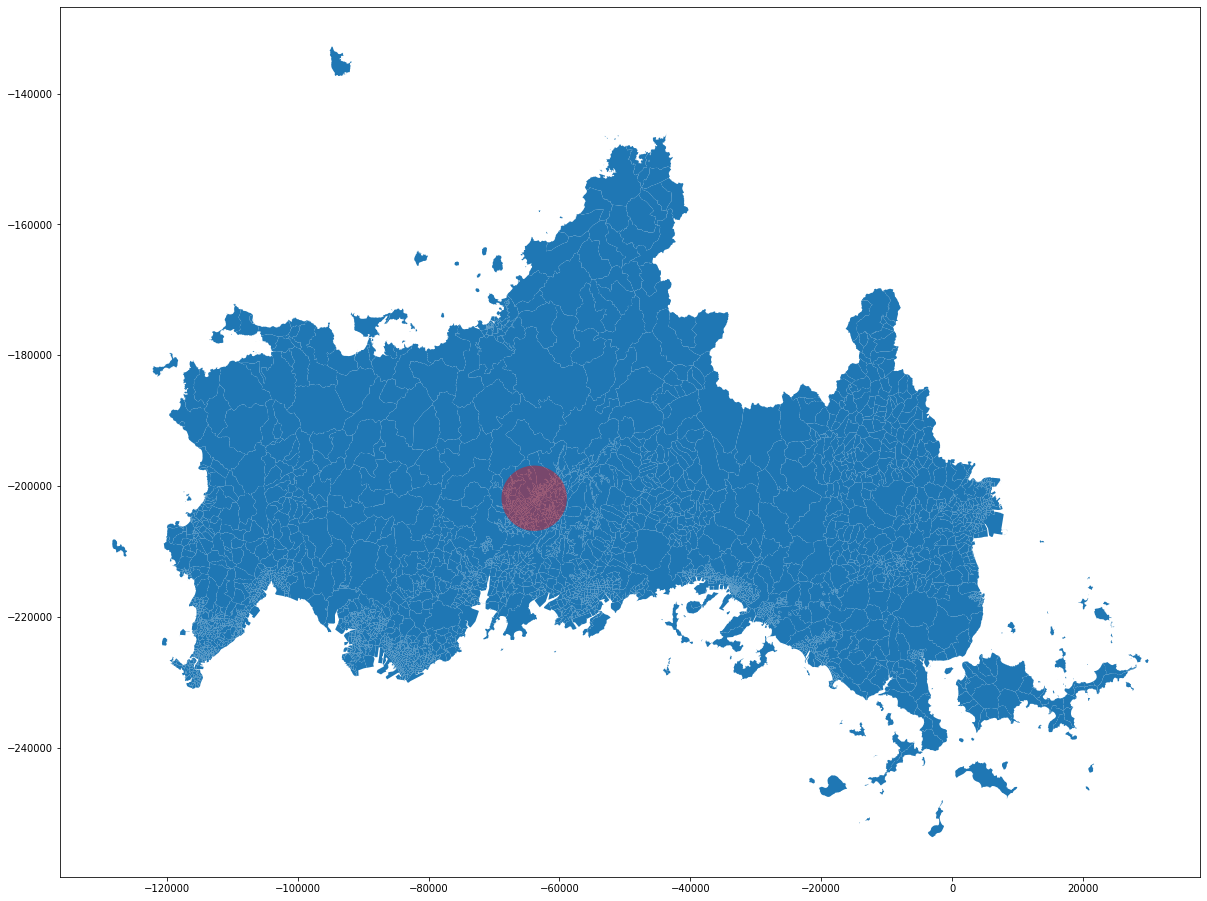

In [ ]:
# 店舗の定義
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# 地理情報データの読み込み
yamaguchi = gpd.read_file(r'/content/drive/My Drive/BASE2/GeoData/e-stat/Yamaguchi/h27ka35.shp')
yamaguchi = yamaguchi[yamaguchi['HCODE'] != 8154] # 水面調査区の除去

# 投影座標系の変換（平面直角座標系への変換）
projected_yamaguchi = yamaguchi.to_crs('EPSG:2445', inplace=False)

# 山口市中心部(北緯 34.178295度，東経 131.473843度)に仮想店舗を設置する
# (メモ) Point の引数は (経度, 緯度)
shop = gpd.GeoDataFrame([['shopA', Point(131.473843, 34.178295)]],
                        columns=['name', 'geometry'],
                        crs='EPSG:4612')

market_area = shop.to_crs('EPSG:2445', inplace=False) #  平面直角座標系へ変換

# 半径 5km (5000m) のポリゴンを生成
buffer_size = 5000 # 5000[m] = 5[km]
market_area['geometry'] = market_area.buffer(buffer_size)

# 可視化
fig, ax = plt.subplots(1, figsize=(32, 16))
projected_yamaguchi.plot(ax=ax)
market_area.plot(ax=ax, color="red", alpha=0.4)

### 商圏内の人口を求める
(注意) 以下では projected_yamaguchi から「要りそうな情報」のみを取り出しているが，これは表にした際に見易くするための操作であり，本質的でない。

In [ ]:
# 山口県の元データの列が多いため，一部（要りそうな情報のみ）取り出す
# 要りそうな情報：市名(CITY_NAME)，町丁・字等名称(S_NAME)，面積(AREA)，人口(JINKO), geometry
projected_yamaguchi = projected_yamaguchi[['CITY_NAME', 'S_NAME', 'AREA', 'JINKO', 'geometry']]

In [ ]:
# 山口の地理情報と商圏を空間的に結合(spatial join)する
joined = gpd.sjoin(projected_yamaguchi, market_area, op='within')

In [ ]:
# 空間結合されたデータの中身を確認
joined.head()

,CITY_NAME,S_NAME,AREA,JINKO,geometry,index_right,name
1233,山口市,木町,81220.080,294,"POLYGON ((-63635.106 -200504.728, -63637.169 -...",0,shopA
1234,山口市,香山町,91437.232,228,"POLYGON ((-63740.770 -200753.435, -63747.000 -...",0,shopA
1235,山口市,水の上町,97080.830,170,"POLYGON ((-63776.733 -201082.455, -63813.781 -...",0,shopA
1236,山口市,金古曽町,77718.865,349,"POLYGON ((-62753.492 -201201.570, -62855.506 -...",0,shopA
1237,山口市,石観音町,31367.439,157,"POLYGON ((-62991.170 -201373.151, -63051.179 -...",0,shopA


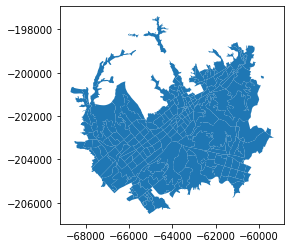

In [ ]:
# 空間結合されたデータの可視化
joined.plot()

In [ ]:
# 商圏内に町丁・字等名称(S_NAME)が何件含まれるか，見ておく
len(joined)

251

In [ ]:
# 商圏人口の算出
for name, group in joined.groupby('name'):
    total_pop = group['JINKO'].sum()
    print("{} の商圏人口：{}人".format(name, total_pop))

shopA の商圏人口：98740人


## ステップ２：現実の店舗配置による商圏人口の算出
山口県内で展開しているスーパー・チェーン「まるき」（株式会社 丸喜）を取り上げる。

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# 地理情報データの読み込み
yamaguchi = gpd.read_file(r'/content/drive/My Drive/BASE2/GeoData/e-stat/Yamaguchi/h27ka35.shp')
yamaguchi = yamaguchi[yamaguchi['HCODE'] != 8154] # 水面調査区の除去

# 投影座標系の変換（平面直角座標系への変換）
projected_yamaguchi = yamaguchi.to_crs('EPSG:2445', inplace=False)

# まるき店舗データの読み込み
maruki = pd.read_excel('/content/drive/My Drive/BASE2/GeoData/maruki.xlsx')

# 店舗の定義
# [[店舗名A, Point(経度A,緯度A)], [店舗名B, Point(経度B,緯度B)], [店舗名C, Point(経度C,緯度C)]] の形のリストを作る
number_of_shop = len(maruki)
shop_list = list()
for idx in range(number_of_shop):
    data = maruki.iloc[idx]
    shop_list.append([data['店舗名'], Point(data['経度'], data['緯度'])])

## Point の引数は (経度, 緯度)
shops = gpd.GeoDataFrame(shop_list,
                         columns=['name', 'geometry'], crs='EPSG:4612')

market_area = shops.to_crs('EPSG:2445', inplace=False) # 投影座標系の変換

# 半径 buffer_size のポリゴンを生成
buffer_size = 3000 # 3000[m] = 3[km]
market_area['geometry'] = market_area.buffer(buffer_size)

### 空間的に結合した上での可視化

In [ ]:
# 山口の地理情報と商圏を空間的に結合(spatial join)する
joined = gpd.sjoin(projected_yamaguchi, market_area, op='within')

In [ ]:
joined.head()

,KEY_CODE,PREF,CITY,S_AREA,PREF_NAME,CITY_NAME,S_NAME,KIGO_E,HCODE,AREA,PERIMETER,H27KAxx_,H27KAxx_ID,KEN,KEN_NAME,SITYO_NAME,GST_NAME,CSS_NAME,KIHON1,DUMMY1,KIHON2,KEYCODE1,KEYCODE2,AREA_MAX_F,KIGO_D,N_KEN,N_CITY,KIGO_I,MOJI,KBSUM,JINKO,SETAI,X_CODE,Y_CODE,KCODE1,geometry,index_right,name
4,35201003003,35,201,003003,山口県,下関市,本町３丁目,None,8101,98355.229,1720.175,3447,3446,35,山口県,None,下関市,None,0030,-,03,201003003,201003003,M,None,None,None,None,本町３丁目,10,217,108,130.94776,33.96626,0030-03,"POLYGON ((-112602.892 -225064.945, -112596.346...",24,まるき武久店
13,35201010001,35,201,010001,山口県,下関市,貴船町１丁目,None,8101,85250.573,1291.718,2279,2278,35,山口県,None,下関市,None,0100,-,01,201010001,201010001,M,None,None,None,None,貴船町１丁目,20,655,328,130.94406,33.96415,0100-01,"POLYGON ((-112825.789 -225212.487, -112861.749...",24,まるき武久店
14,35201010002,35,201,010002,山口県,下関市,貴船町２丁目,None,8101,129996.708,1761.084,1553,1552,35,山口県,None,下関市,None,0100,-,02,201010002,201010002,M,None,None,None,None,貴船町２丁目,22,461,211,130.94426,33.96632,0100-02,"POLYGON ((-113052.709 -225025.357, -113059.568...",24,まるき武久店
15,35201010003,35,201,010003,山口県,下関市,貴船町３丁目,None,8101,180161.457,2177.559,2739,2738,35,山口県,None,下関市,None,0100,-,03,201010003,201010003,M,None,None,None,None,貴船町３丁目,20,814,331,130.94364,33.96927,0100-03,"POLYGON ((-113070.969 -224830.013, -113070.204...",24,まるき武久店
16,35201010004,35,201,010004,山口県,下関市,貴船町４丁目,None,8101,152406.469,1940.972,965,964,35,山口県,None,下関市,None,0100,-,04,201010004,201010004,M,None,None,None,None,貴船町４丁目,15,942,424,130.93958,33.97117,0100-04,"POLYGON ((-113261.447 -224595.241, -113267.432...",24,まるき武久店


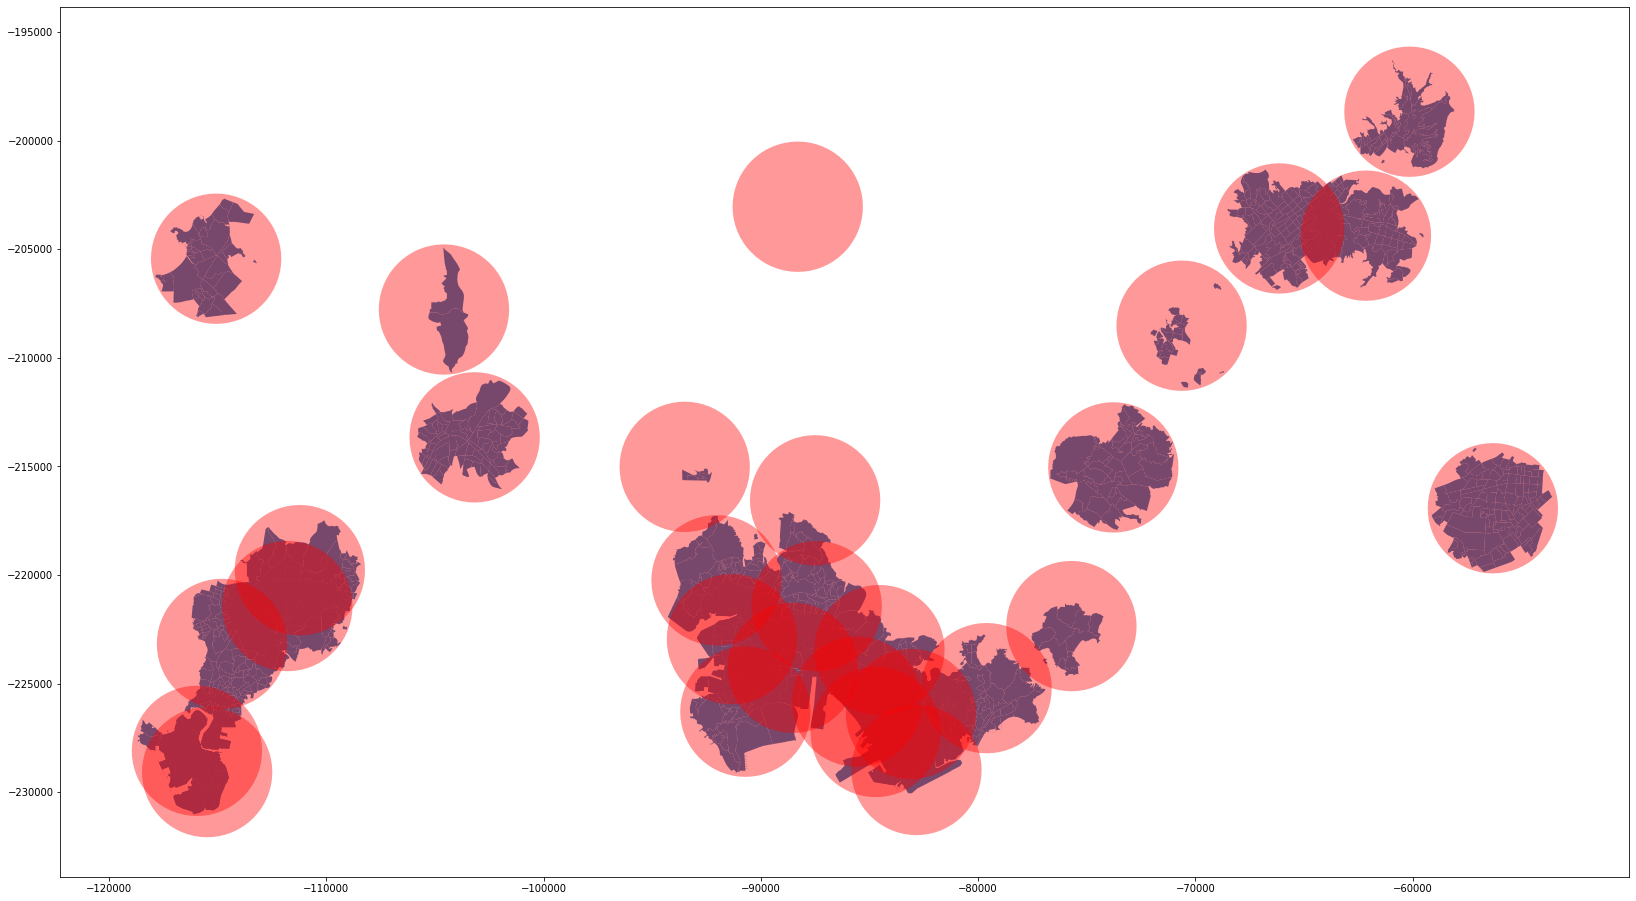

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(32, 16))
joined.plot(ax=ax)
market_area.plot(ax=ax, color='red', alpha=0.4)

### 商圏人口の算出

In [ ]:
print("=== 商圏人口の一覧 ===")
for name, group in joined.groupby('name'):
    total_pop = group['JINKO'].sum()
    print("{}：{}人".format(name, total_pop))

=== 商圏人口の一覧 ===
まるき小野田大学通り店：21558人
まるき山口嘉川店：6763人
まるき常盤通り店：56470人
まるき彦島店：37045人
まるき武久店：76259人
まるき角倉店：26687人
ウェスタまるき下関一の宮店：54041人
ウェスタまるき下関小月店：11988人
ウェスタまるき下関形山店：40054人
ウェスタまるき中川店：28119人
ウェスタまるき厚狭店：665人
ウェスタまるき小松原通り店：48107人
ウェスタまるき小羽山店：36893人
ウェスタまるき小郡店：9040人
ウェスタまるき山口大内店：32182人
ウェスタまるき山口宮野店：10944人
ウェスタまるき山口湯田店：57654人
ウェスタまるき工学部通り店：70055人
ウェスタまるき東岐波店：6811人
ウェスタまるき楠店：1136人
ウェスタまるき神田店：18347人
ウェスタまるき空港通り店：35393人
ウェスタまるき菊川店：3175人
ウェスタまるき華城店：57476人
ウェスタまるき西割店：37969人
ウェスタまるき西宇部店：30285人
ウェスタまるき西岐波店：25820人
ウェスタまるき豊浦店：8089人


# 課題
地域を「宇部市」に限定した上で，前回に収集した「セブンイレブンの位置情報」を利用して，セブンイレブンの商圏人口を求めよ。

ただし，スーパーと異なり，コンビニエンスストアの商圏は
- 都市部では「歩いて約５分（約350〜500m)」とされるが，
- 山口県は車社会だから ２km に設定してください。

### 余談
2019年11月24日の日本経済新聞に「コンビニ、縮む商圏　9割が店舗当たり人口3000人未満」という記事が掲載されました。

https://www.evernote.com/u/0/Home.action#?n=5e2e363e-f46f-4de3-b67e-8923b3fe0b01&b=1223653d-1e96-4569-8267-21d36783f896&legacy=p
